BEER CLASSIFICATION PROJECT

# Notebook 3 - Model Selection

This notebook will be used to evaluate multiple model families and pick one to move forward with.

In [1]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV,  StratifiedKFold, cross_validate, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, top_k_accuracy_score, f1_score, log_loss, precision_score, recall_score, roc_auc_score
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
from matplotlib.colors import rgb2hex
import seaborn as sns
import textwrap
sns.set_theme(style="white")
%matplotlib inline

In [2]:
sns.set_style("white")
sns.set_palette("Blues")
main_cmap = sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True)
main_color = main_cmap(0.75)
main_color = rgb2hex(main_color)

# Import

## Import File

Again, we'll first read in the merged, transformed dataset

In [3]:
df = pd.read_parquet('./data/processed/df_processed')

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3170 entries, 0 to 3196
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   abv          3170 non-null   float64 
 1   min_ibu      3170 non-null   int64   
 2   max_ibu      3170 non-null   int64   
 3   astringency  3170 non-null   int64   
 4   body         3170 non-null   int64   
 5   alcohol      3170 non-null   int64   
 6   bitter       3170 non-null   int64   
 7   sweet        3170 non-null   int64   
 8   sour         3170 non-null   int64   
 9   salty        3170 non-null   int64   
 10  fruits       3170 non-null   int64   
 11  hoppy        3170 non-null   int64   
 12  spices       3170 non-null   int64   
 13  malty        3170 non-null   int64   
 14  style_l1     3170 non-null   category
dtypes: category(1), float64(1), int64(13)
memory usage: 375.9 KB
None


,abv,min_ibu,max_ibu,astringency,body,alcohol,bitter,sweet,sour,salty,fruits,hoppy,spices,malty,style_l1
0,5.3,25,50,13,32,9,47,74,33,0,33,57,8,111,Altbier
1,7.2,25,50,12,57,18,33,55,16,0,24,35,12,84,Altbier
2,5.0,25,50,14,37,6,42,43,11,0,10,54,4,62,Altbier
3,8.5,25,50,13,55,31,47,101,18,1,49,40,16,119,Altbier
4,7.2,25,50,25,51,26,44,45,9,1,11,51,20,95,Altbier


---

## Model Selection prep

We're going to treat this a bit like a survey of model types for multiclass classification - we'll try out Logistic Regression, KNN, SVC, Histogram Gradient Boosting Trees, and Random Forest.

Before we outline the model selection paradigm we'll use, let's get familiar with multiclass scoring metrics in sklearn, with a simple logistic regression.

### Set parameters

In [4]:
# Create X, y
X = df.drop(columns='style_l1')
y = df['style_l1'].astype('category')

# Set random state
r = 0

# Stratified train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=r, stratify=y)

### Scoring Choice

Before we run the full pipe, let's take a single `LogisticRegression` estimator to try out the different scoring metrics, pick what we want to report and what we want to use in our gridsearch.

In [5]:
basic_logreg = LogisticRegression(penalty='l2', C=0.01, multi_class='ovr', max_iter=1000)
basic_logreg.fit(X_train, y_train)

y_preds = basic_logreg.predict(X_train)
y_preds_prob = basic_logreg.predict_proba(X_train)

In [6]:
# Confusion matrix
confusion_matrix(y_true=y_train, y_pred=y_preds)

array([[  1,   0,   3, ...,   0,   0,   0],
       [  0,  38,   0, ...,   0,   0,   1],
       [  0,   0,  25, ...,   0,   0,   0],
       ...,
       [  0,   1,   0, ..., 117,   0,   0],
       [  0,   0,   0, ...,   0,  12,   0],
       [  0,   0,   0, ...,   0,   0,  21]])

In [7]:
# Accuracy
print('Accuracy score is {:.3f}'.format(accuracy_score(y_train, y_preds)))

Accuracy score is 0.589


In [8]:
# Balanced accuracy - average of recall across classes
print('Balanced accuracy score is {:.3f}'.format(balanced_accuracy_score(y_train, y_preds)))

Balanced accuracy score is 0.485


In [9]:
# Top-k accuracy
print('Top-3 accuracy score is {:.3f}'.format(top_k_accuracy_score(y_train, y_preds_prob, k=3)))

Top-3 accuracy score is 0.865


In [10]:
# Precision
print('Micro-averaged precision is {:.3f}'.format(precision_score(y_train, y_preds, average='micro')))
print('Macro-averaged precision is {:.3f}'.format(precision_score(y_train, y_preds, average='macro')))
print('Weighted-averaged precision is {:.3f}'.format(precision_score(y_train, y_preds, average='weighted')))

Micro-averaged precision is 0.589
Macro-averaged precision is 0.684
Weighted-averaged precision is 0.600


/Users/andrewtaylor/opt/anaconda3/envs/beerclass/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/andrewtaylor/opt/anaconda3/envs/beerclass/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
# Recall
print('Micro-averaged recall is {:.3f}'.format(recall_score(y_train, y_preds, average='micro')))
print('Macro-averaged recall is {:.3f}'.format(recall_score(y_train, y_preds, average='macro')))
print('Weighted-averaged recall is {:.3f}'.format(recall_score(y_train, y_preds, average='weighted')))

Micro-averaged recall is 0.589
Macro-averaged recall is 0.485
Weighted-averaged recall is 0.589


In [12]:
# F1
print('Micro-averaged F1 is {:.3f}'.format(f1_score(y_train, y_preds, average='micro')))
print('Macro-averaged F1 is {:.3f}'.format(f1_score(y_train, y_preds, average='macro')))
print('Weighted-averaged F1 is {:.3f}'.format(f1_score(y_train, y_preds, average='weighted')))

Micro-averaged F1 is 0.589
Macro-averaged F1 is 0.530
Weighted-averaged F1 is 0.554


In [13]:
# Set metrics for scoring
scoring_metrics = ['accuracy', 'balanced_accuracy', 'precision_micro', 'precision_macro', 'precision_weighted', 'recall_micro', 'recall_macro', 'recall_weighted', 'f1_micro', 'f1_macro', 'f1_weighted']
cv_scoring_metric = 'balanced_accuracy'

#### Decision

**Cross-validation scoring:** We'll use balanced accuracy as our metric (essentially macro-averaged recall) because it accounts for our imbalanced classes.
**Other evaluation:** For each model, we'll store all of the metrics above for comparison purposes. After we select a model and hyperparameters, we'll deep-dive the model with more interesting summaries of the results.

---

## Model Selection

For all model types, since our smallest class has just 19 observations, we'll use nested cross-validation to preserve the amount of data used to select hyperparameters and models. For each model type (e.g. Logistic Regression, Gradient Boosting Classifier), we'll use an 'inner' cross-validation loop with 5 folds to pick the best hyperparameters for that model type. Then, we'll use an 'outer' loop with 10 folds to get an unbiased estimate of how the model type performs.

In nested CV, within each 'outer' loop run, a separate inner loop will be run, which can potentially select different hyperparameters. This means we have to make two decisions - which model type we move forward with, and which hyperparameters we use for that model type. We'll use the average scoring across our outer loop to select the model type, then select the hyperparameters which presented themselves the most frequently *across* outer loop runs. Ideally, our hyperparameters are stable enough that one combination of them was the 'best' at least twice out of the 10 outer loop folds. If not, we'll deal with it on a one-off basis.

Within some model types, we'll also use scikit-learn's `Pipeline` to perform any needed preprocessing and feature selection.

In [13]:
# Create the outer loop cv
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=r)

# Create the inner loop cv
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=r)

# Create output DataFrame
model_select_df = pd.DataFrame(columns=['model_type', 'best_params', 'best_num_runs', 'best_score', 'best_diff_to_second'] +
                                       ['mean_test_'+a for a in scoring_metrics])
out_detail_df = pd.DataFrame(columns=['params', cv_scoring_metric+'_count', cv_scoring_metric+'_mean'])

In [14]:
def run_and_store(pipe, X, y, param_grid, inner_cv, outer_cv, cv_scoring_metric, scoring_metrics, model_name, out_df, out_detail_df, verb=0):
    '''Runs the given pipeline in a nested cv and returns an updated output dataframe'''

    model = GridSearchCV(pipe, param_grid, cv=inner_cv, scoring=cv_scoring_metric, refit=True)


    scores = cross_validate(model, X, y, cv=outer_cv, scoring=scoring_metrics, n_jobs=-1, return_estimator=True, verbose=verb)
    outs = pd.DataFrame([[str(est.best_params_), scores['test_'+cv_scoring_metric][ind]] for ind, est in
                                 enumerate(scores['estimator'])],
                                columns=['params', cv_scoring_metric])
    picked = (
        outs
            .groupby(['params'], as_index=False)
            .agg(['count', 'mean'])
            .sort_values([(cv_scoring_metric, 'count'), (cv_scoring_metric, 'mean')], ascending=False)
    )

    best_params = picked.index[0]
    best_num_folds = picked.iloc[0, 0]
    best_score = picked.iloc[0, 1]
    try:
        best_diff_to_second = picked.iloc[0, 1] - picked.iloc[1, 1]
    except:
        best_diff_to_second = np.nan

    out_dict = {'model_type': model_name,
                'best_params': best_params,
                'best_num_runs': best_num_folds,
                'best_score': best_score,
                'best_diff_to_second': best_diff_to_second
                }

    out_scores = [{'mean_' + key: value.mean()} for key, value in scores.items() if 'test_' in key]

    for score in out_scores:
        out_dict.update(score)

    new_out_df = pd.concat([out_df, pd.DataFrame([out_dict])])

    picked.columns = [a+'_'+b for (a, b) in list(picked.columns)]
    picked = picked.reset_index()

    new_out_detail_df = pd.concat([out_detail_df, picked])

    return new_out_df, new_out_detail_df

### Logistic Regression

We'll start with logistic regression. Because logistic regression is affected by multicollinearity (which we saw during EDA), we'll fit a pipeline with PCA for dimensionality reduction. We'll also scale beforehand, since PCA requires scaling. Then, we'll try out fits for a regular, lasso, and ridge regression.

We're going to stay within the `scikit-learn` family on this, so we'll be using the `sklearn.linear_model.LogisticRegression` estimator. We'll gridsearch over a few variants. First and foremost, we'll look at both the `multinomial` and `ovr` options for the `multi_class` paramater. This will compare a multinomial regression to a one-vs-all meta-scheme. Without going WAY deep, the one-vs-rest scheme sets up a binary classifiers for each class to estimate the of "in the class" vs "not in the class", and the multinomial classifier generates one fewer regressions, and works by regressing against the probability of being in a "base" class.

https://datascience.stackexchange.com/questions/77813/logistic-regression-does-cannot-converge-without-poor-model-performance

#### Non-regularized

In [15]:
# Create the scaler
scaler = StandardScaler()

# Create the PCA object
pca = PCA()

# Create the logistic regression object
logregnr_estimator = LogisticRegression(max_iter=1000)

# Create the Pipeline object
logregnr_pipe = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('estimator', logregnr_estimator)])

# Create the parameter grid for searching
logregnr_param_grid = [
    {
        "pca__n_components": [4, 6],
        "estimator__penalty": ['none'],
        "estimator__multi_class": ['auto', 'ovr'],
        
    },
]

In [16]:
model_select_df, out_detail_df = run_and_store(logregnr_pipe, X_train, y_train, logregnr_param_grid, inner_cv, outer_cv, cv_scoring_metric, scoring_metrics, 'Logistic Regression - No Reg', model_select_df, out_detail_df)

/Users/andrewtaylor/opt/anaconda3/envs/beerclass/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/andrewtaylor/opt/anaconda3/envs/beerclass/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

#### LASSO

In [17]:
# Create the scaler
scaler = StandardScaler()

# Create the PCA object
pca = PCA()

# Create the logistic regression object
logreglasso_estimator = LogisticRegression(max_iter=1000)

# Create the Pipeline object
logreglasso_pipe = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('estimator', logreglasso_estimator)])

# Create the parameter grid for searching
logreglasso_param_grid = [
    {
        "pca__n_components": [4, 6],
        "estimator__penalty": ['none'],
        "estimator__penalty": ['l1'],
        "estimator__C": [0.01, 1, 100, 10000],
        "estimator__multi_class": ['auto', 'ovr'],
        "estimator__solver": ["liblinear"]
    },
]

In [18]:
model_select_df, out_detail_df = run_and_store(logreglasso_pipe, X_train, y_train, logreglasso_param_grid, inner_cv, outer_cv, cv_scoring_metric, scoring_metrics, 'Logistic Regression - Lasso', model_select_df, out_detail_df)

/Users/andrewtaylor/opt/anaconda3/envs/beerclass/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/andrewtaylor/opt/anaconda3/envs/beerclass/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/andrewtaylor/opt/anaconda3/envs/beerclass/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/andrewtaylor/opt/anaconda3/envs/beerclass/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/andrewtaylor/opt/anaconda3/envs/beerclass/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the numb

Note: "failed to converge" warnings only occurring when C = 10000

#### Ridge

In [19]:
# Create the scaler
scaler = StandardScaler()

# Create the PCA object
pca = PCA()

# Create the logistic regression object
logregridge_estimator = LogisticRegression(max_iter=1000)

# Create the Pipeline object
logregridge_pipe = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('estimator', logregridge_estimator)])

# Create the parameter grid for searching
logregridge_param_grid = [
    {
        "pca__n_components": [4, 6],
        "estimator__penalty": ['none'],
        "estimator__penalty": ['l2'],
        "estimator__C": [0.01, 1, 100, 10000],
        "estimator__multi_class": ['auto', 'ovr'],
        "estimator__solver": ["lbfgs"]
    },
]

In [20]:
model_select_df, out_detail_df = run_and_store(logregridge_pipe, X_train, y_train, logregridge_param_grid, inner_cv, outer_cv, cv_scoring_metric, scoring_metrics, 'Logistic Regression - Ridge', model_select_df, out_detail_df)

/Users/andrewtaylor/opt/anaconda3/envs/beerclass/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/andrewtaylor/opt/anaconda3/envs/beerclass/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

### SVC

Next, we'll take a look at a Support Vector Classifier. Again, we'll need scaled data with multicollinearity handled, so we'll run a `StandardScaler` and PCA beforehand. 

After that, the main thing we can toy around with is the kernel (we'll just look at the RBF kernel as a nonlinear alternative to the linear), and C, the regularization parameter.

In [21]:
# Create the scaler
scaler = StandardScaler()

# Create the PCA object
pca = PCA()

# Create the estimator object
svc_estimator = SVC(max_iter=1000)

# Create the Pipeline object
svc_pipe = Pipeline(
    steps=[
        ('scaler', scaler),
        ('pca', pca),
        ('estimator', svc_estimator)
        ])

# Create the parameter grid for searching
svc_param_grid = [
    {
        "pca__n_components": [4, 6],
        "estimator__kernel": ['rbf', 'linear'],
        "estimator__C": [0.01, 1, 100, 10000],
    }
]

In [22]:
model_select_df, out_detail_df = run_and_store(svc_pipe, X_train, y_train, svc_param_grid, inner_cv, outer_cv, cv_scoring_metric, scoring_metrics, 'SVC', model_select_df, out_detail_df)

/Users/andrewtaylor/opt/anaconda3/envs/beerclass/lib/python3.10/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/andrewtaylor/opt/anaconda3/envs/beerclass/lib/python3.10/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/andrewtaylor/opt/anaconda3/envs/beerclass/lib/python3.10/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/andrewtaylor/opt/anaconda3/envs/beerclass/lib/python3.10/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
 

Note - convergence warnings happen at all C except C=0.01 for linear kernel and all except C=0.01, 1 for RBF kernel.

### HGBT

Next, we'll look at Histogram Gradient Boosting Trees. This is scikit-learn's LightGBM-inspired estimator. It speeds up typical gradient boosting by binning the input samples, "greatly reducing the number of potential split points and allowing for integer- based data structures" [(source)](https://scikit-learn.org/stable/modules/ensemble.html#histogram-based-gradient-boosting).

In [23]:
# Create the estimator object
hgbt_estimator = HistGradientBoostingClassifier()

# Create the Pipeline object
hgbt_pipe = Pipeline(steps=[('estimator', hgbt_estimator)])

# Create the parameter grid for searching
hgbt_param_grid = [
    {
        "estimator__max_iter": [250, 500],
        "estimator__max_depth": [4, 8],
        "estimator__learning_rate": [0.01, 0.04],
    }
]

In [24]:
model_select_df, out_detail_df = run_and_store(hgbt_pipe, X_train, y_train, hgbt_param_grid, inner_cv, outer_cv, cv_scoring_metric, scoring_metrics, 'HGBT', model_select_df, out_detail_df)

/Users/andrewtaylor/opt/anaconda3/envs/beerclass/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/andrewtaylor/opt/anaconda3/envs/beerclass/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/andrewtaylor/opt/anaconda3/envs/beerclass/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

### Random Forest

The last type of classifier we'll try is a random forest. It should provide similar benefits to the gradient boosting classifier - it's another tree-based method which may provide a better mechanism for capturing the relationships between our predictors and the many classes.

In [25]:
# Create the estimator object
rf_estimator = RandomForestClassifier()

# Create the Pipeline object
rf_pipe = Pipeline(steps=[('estimator', rf_estimator)])

# Create the parameter grid for searching
rf_param_grid = [
    {
        "estimator__n_estimators": [250, 500],
        "estimator__max_depth": [4, 8, 16, 32],
        'estimator__min_samples_split': [2, 5, 10]
    }
]

In [26]:
model_select_df, out_detail_df = run_and_store(rf_pipe, X_train, y_train, rf_param_grid, inner_cv, outer_cv, cv_scoring_metric, scoring_metrics, 'Random Forest', model_select_df, out_detail_df)

/Users/andrewtaylor/opt/anaconda3/envs/beerclass/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/andrewtaylor/opt/anaconda3/envs/beerclass/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/andrewtaylor/opt/anaconda3/envs/beerclass/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

## Model Selection

* Did all models select somewhat approprimate hyperparamters?
* What model performed the best on which measures?
* What model do we move forward with?

### Analysis

In [14]:
model_select_df = pd.read_parquet('data/model_select')
model_select_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 0
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   model_type                    6 non-null      object 
 1   best_params                   6 non-null      object 
 2   best_num_runs                 6 non-null      int64  
 3   best_score                    6 non-null      float64
 4   best_diff_to_second           5 non-null      float64
 5   mean_test_accuracy            6 non-null      float64
 6   mean_test_balanced_accuracy   6 non-null      float64
 7   mean_test_precision_micro     6 non-null      float64
 8   mean_test_precision_macro     6 non-null      float64
 9   mean_test_precision_weighted  6 non-null      float64
 10  mean_test_recall_micro        6 non-null      float64
 11  mean_test_recall_macro        6 non-null      float64
 12  mean_test_recall_weighted     6 non-null      float64
 13  mean_test

In [15]:
def plot_and_compare(df, score_col, score_name, ax, lsize):
    # print(f'\n\n{score_name}')
    ax = sns.barplot(x='model_type', y=score_col, data=df, ax=ax, color=main_color)
    sns.despine()
    ax.set_title(score_name + ' by Model Type')
    ax.set_xlabel('Model Type')
    ax.set_ylabel(score_name)
    ax.set_xticklabels([textwrap.fill(e, 10) for e in df['model_type']])
    ax.tick_params(axis='x', which='both', labelsize=lsize)

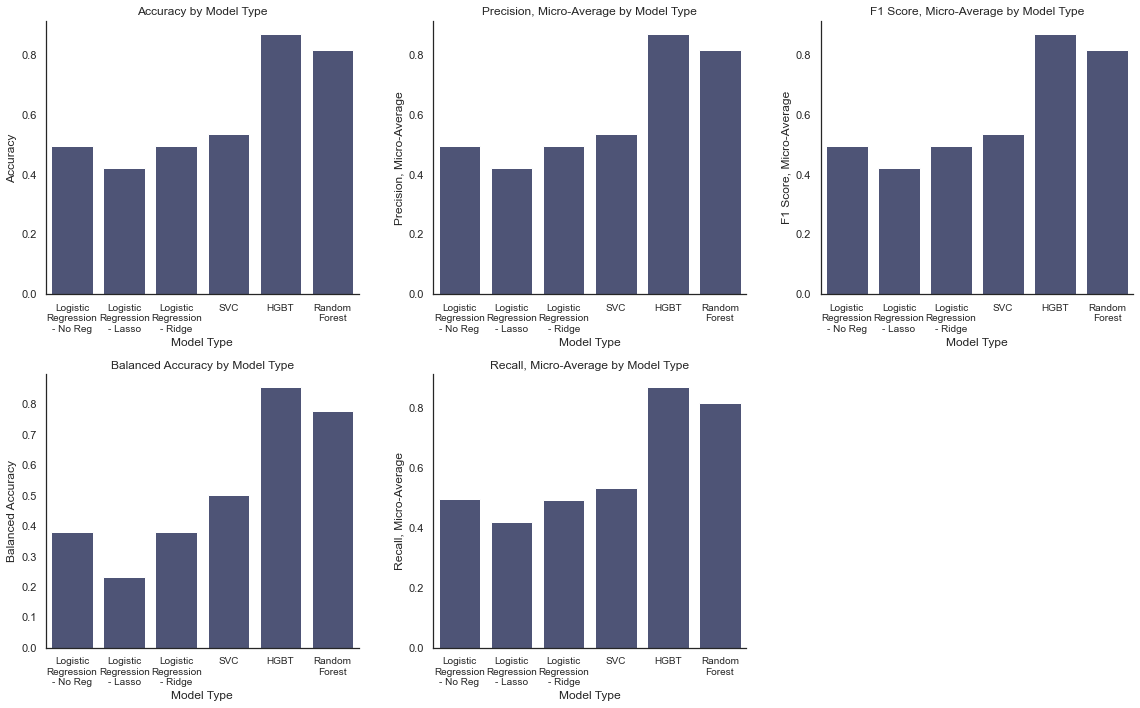

In [16]:
sns.set_context('notebook')
score_names = {
    'mean_test_accuracy': 'Accuracy',
    'mean_test_balanced_accuracy': 'Balanced Accuracy',
    'mean_test_precision_micro': 'Precision, Micro-Average',
    'mean_test_precision_macro': 'Precision, Macro-Average',
    'mean_test_precision_weighted': 'Precision, Weighted-Average',
    'mean_test_recall_micro': 'Recall, Micro-Average',
    'mean_test_recall_macro': 'Recall, Macro-Average',
    'mean_test_recall_weighted': 'Recall, Weighted-Average',
    'mean_test_f1_micro': 'F1 Score, Micro-Average',
    'mean_test_f1_macro': 'F1 Score, Macro-Average',
    'mean_test_f1_weighted': 'F1 Score, Weighted-Average',
}

fig, axes = plt.subplots(ncols=3, nrows=2)
fig.set_size_inches(16, 10)

scoring_metrics_limited = [a for a in scoring_metrics if ('macro' not in a) and ('weighted' not in a)]

for i, score_col in enumerate(['mean_test_'+a for a in scoring_metrics_limited]):
    plot_and_compare(model_select_df, score_col, score_names[score_col], ax=axes[i % 2, int(i / 2)], lsize=10)

fig.delaxes(axes[1][2])
plt.tight_layout(w_pad=3)
plt.savefig('figures/model_scores.png')

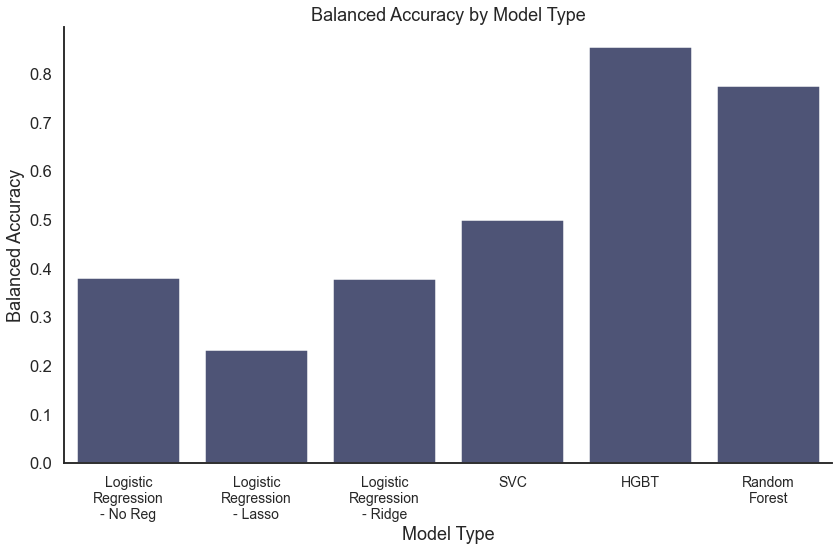

In [18]:
sns.set_context('talk')
fig, ax = plt.subplots(figsize=(12, 8))

score_col = 'mean_test_balanced_accuracy'

plot_and_compare(model_select_df, score_col, score_names[score_col], ax=ax, lsize=14)

plt.tight_layout()
plt.savefig('figures/model_balanced_accuracy.png')

In [47]:
for row in model_select_df.iterrows():
    print(row[1]['model_type'], "-\t", row[1]['best_params'])

Logistic Regression - No Reg -	 {'estimator__multi_class': 'auto', 'estimator__penalty': 'none', 'pca__n_components': 6}
Logistic Regression - Lasso -	 {'estimator__C': 100, 'estimator__multi_class': 'auto', 'estimator__penalty': 'l1', 'estimator__solver': 'liblinear', 'pca__n_components': 6}
Logistic Regression - Ridge -	 {'estimator__C': 10000, 'estimator__multi_class': 'auto', 'estimator__penalty': 'l2', 'estimator__solver': 'lbfgs', 'pca__n_components': 6}
SVC -	 {'estimator__C': 10000, 'estimator__kernel': 'rbf', 'pca__n_components': 6}
HGBT -	 {'estimator__learning_rate': 0.04, 'estimator__max_depth': 8, 'estimator__max_iter': 500}
Random Forest -	 {'estimator__max_depth': 16, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 500}


In [30]:
# Cache dataframes for future work
out_detail_df.to_parquet('data/out_detail')
model_select_df.to_parquet('data/model_select')

### Observations

In [31]:
model_select_df.head(6)

,model_type,best_params,best_num_runs,best_score,best_diff_to_second,mean_test_accuracy,mean_test_balanced_accuracy,mean_test_precision_micro,mean_test_precision_macro,mean_test_precision_weighted,mean_test_recall_micro,mean_test_recall_macro,mean_test_recall_weighted,mean_test_f1_micro,mean_test_f1_macro,mean_test_f1_weighted
0,Logistic Regression - No Reg,"{'estimator__multi_class': 'auto', 'estimator_...",10,0.380061,NaN,0.493878,0.380061,0.493878,0.393167,0.437896,0.493878,0.380061,0.493878,0.493878,0.368388,0.447576
0,Logistic Regression - Lasso,"{'estimator__C': 100, 'estimator__multi_class'...",5,0.234329,0.017699,0.419009,0.231997,0.419009,0.280542,0.350671,0.419009,0.231997,0.419009,0.419009,0.232202,0.343964
0,Logistic Regression - Ridge,"{'estimator__C': 10000, 'estimator__multi_clas...",7,0.374615,-0.013988,0.493456,0.378811,0.493456,0.393605,0.438047,0.493456,0.378811,0.493456,0.493456,0.367662,0.44727
0,SVC,"{'estimator__C': 10000, 'estimator__kernel': '...",5,0.49985,0.001931,0.533046,0.498885,0.533046,0.491646,0.539219,0.533046,0.498885,0.533046,0.533046,0.474507,0.522663
0,HGBT,"{'estimator__learning_rate': 0.04, 'estimator_...",9,0.861672,0.080754,0.867902,0.853597,0.867902,0.868776,0.871515,0.867902,0.853597,0.867902,0.867902,0.850652,0.862607
0,Random Forest,"{'estimator__max_depth': 16, 'estimator__min_s...",5,0.778092,0.024197,0.81447,0.774889,0.81447,0.818331,0.814272,0.81447,0.774889,0.81447,0.81447,0.78011,0.803917


In [49]:
out_detail_df.style.set_properties(subset=['params'], **{'width-min': '300px'})
out_detail_df.head(50)

,params,balanced_accuracy_count,balanced_accuracy_mean
0,"{'estimator__multi_class': 'auto', 'estimator_...",10,0.380061
0,"{'estimator__C': 100, 'estimator__multi_class'...",5,0.234329
1,"{'estimator__C': 10000, 'estimator__multi_clas...",4,0.21663
2,"{'estimator__C': 10000, 'estimator__multi_clas...",1,0.281804
0,"{'estimator__C': 10000, 'estimator__multi_clas...",7,0.374615
1,"{'estimator__C': 100, 'estimator__multi_class'...",3,0.388603
0,"{'estimator__C': 10000, 'estimator__kernel': '...",5,0.49985
1,"{'estimator__C': 100, 'estimator__kernel': 'rb...",5,0.497919
0,"{'estimator__learning_rate': 0.04, 'estimator_...",9,0.861672
1,"{'estimator__learning_rate': 0.04, 'estimator_...",1,0.780918


#### Logistic Regression
It looks like the best logistic regression models are either without regularization or with l2 regularization. This makes sense - we've already reduced to 4-6 principal components, so we shouldn't need much penalization to model complexity. We can also see that C-values of 10,000 were most often selected, which supports the idea that little regulariztion is needed. There was instability in the parameter selection, especially in LASSO, which could be further investigated if it becomes relevant.

#### SVC
 Unsurprisingly, the more flexible kernel (RBF) provided best results. All 10 folds selcted a C value of 100.

#### HGBT

Interestingly, the higher depth was selected (8), which isn't necessarily needed in a boosting algorithm. In addition, the faster learning rate was also chosen every time. In one instance, the lower number of boosters (250) was picked.

#### Random Forest
This one was not incredibly consistent - ultimately, a depth of 16 was picked, along with the most trees in the forest. The lowest min_samples_split was also picked to allow for the deepest trees and smallest leaves.

### Model Selection

Overall, the HGBT and RF models far outperformed the others. This might not be too surprising, given the nature of the data to be well-described by tree-based algorithms, as well as the fact that there are so many classes for the algorithms to deal with. 

We'll move forward with the HGBT. In the next notebook, we'll use the full train dataset to train the model and make a final parameter selection, then evaluate performance on our held-out test set.